In [1]:
import os
os.chdir('../..')

In [169]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew

In [170]:
input_path = r'C:\Users\Wojtek\Documents\Projects\MLPlayground\data\house_prices'
train_file = r'train.csv'
test_file = r'test.csv'

In [171]:
train = pd.read_csv(os.path.join(input_path, train_file))
test = pd.read_csv(os.path.join(input_path, test_file))

In [172]:
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [173]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

In [174]:
test.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


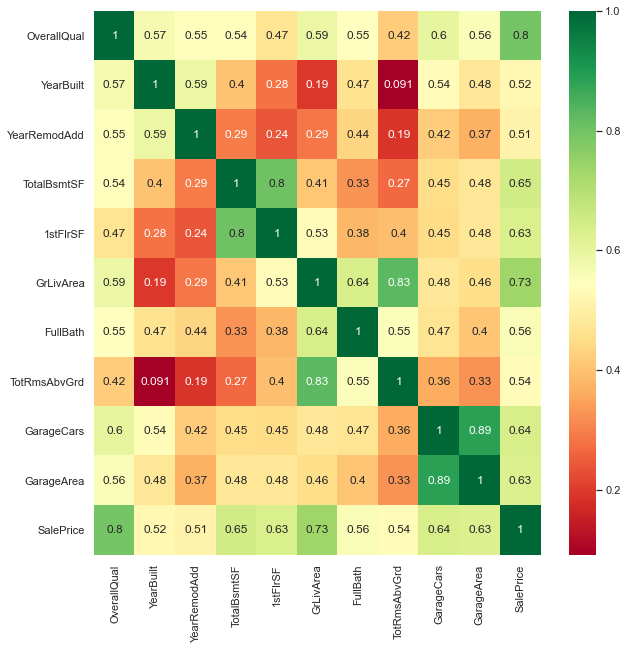

In [175]:
# most correlated features
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


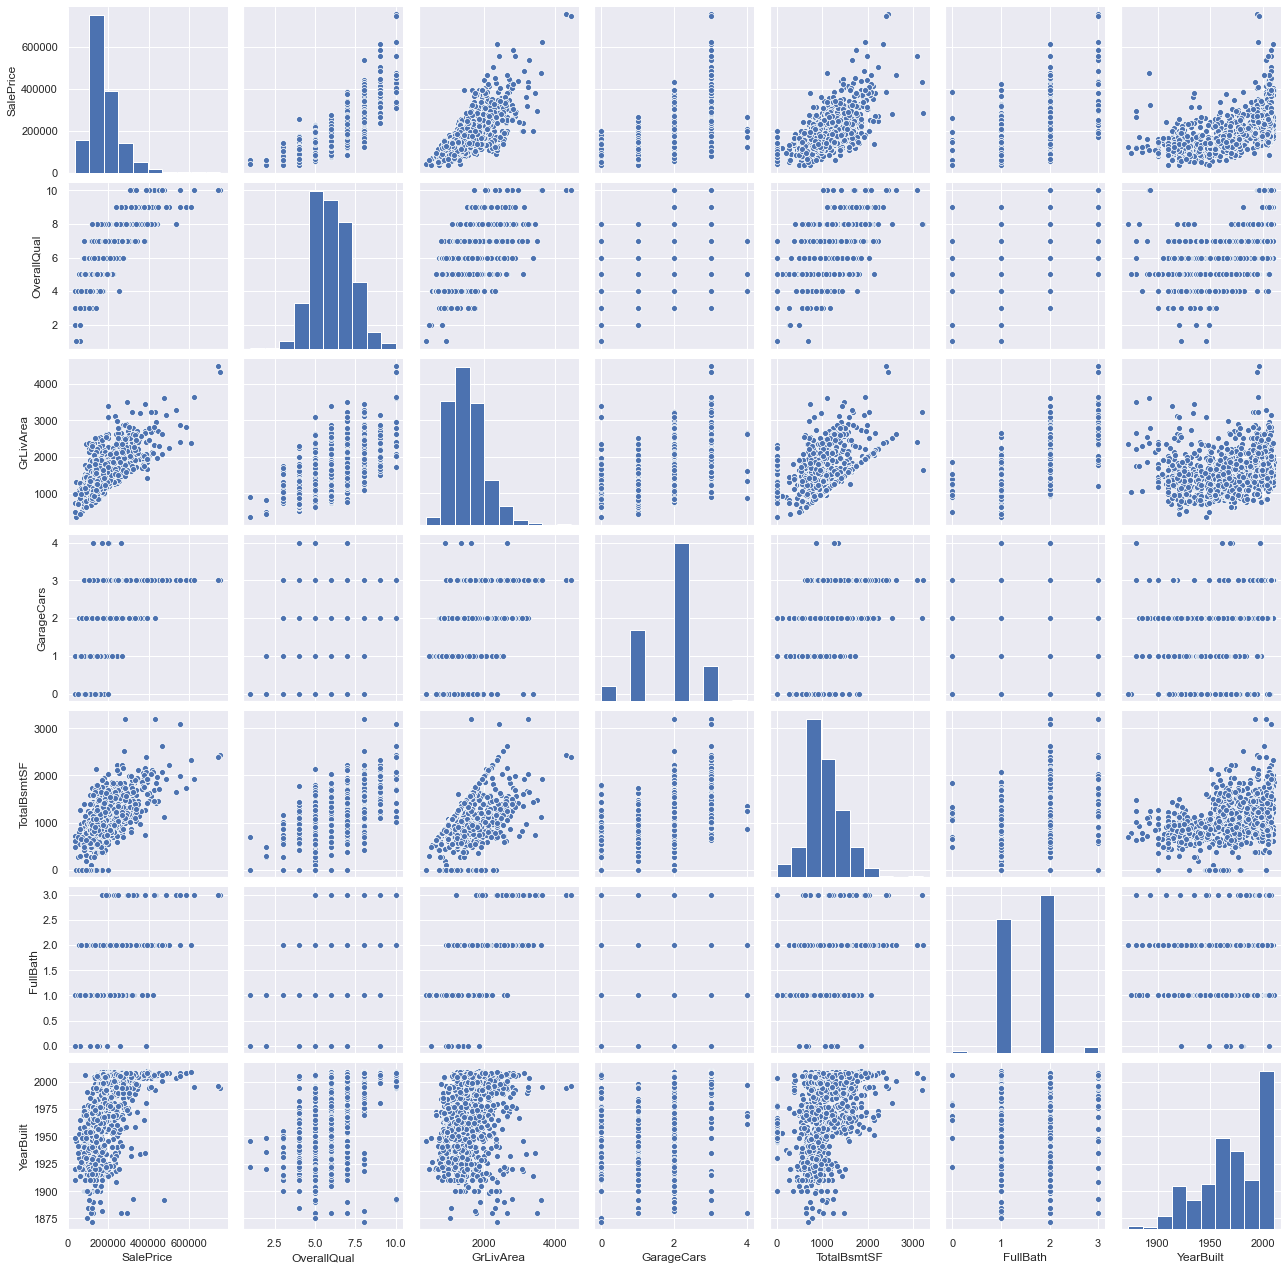

In [176]:
sns.set()
cols =['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size=2.5)
plt.show()


 mu = 180932.92 and sigma = 79467.79



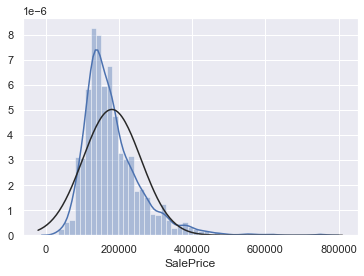

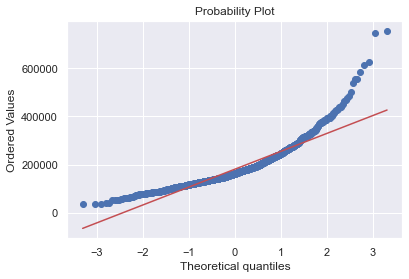

In [177]:
def check_skewness(col):
    sns.distplot(train[col], fit=norm);
    fig = plt.figure()
    res = stats.probplot(train[col], plot=plt)
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(train[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    
check_skewness('SalePrice')


 mu = 12.02 and sigma = 0.40



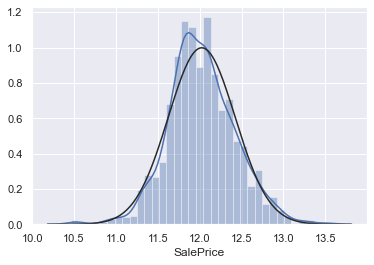

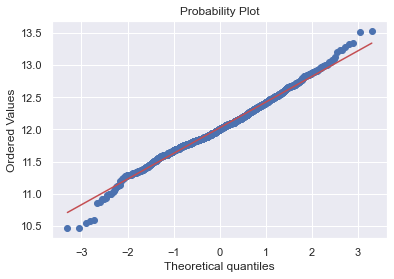

In [178]:
train["SalePrice"] = np.log1p(train["SalePrice"])

check_skewness('SalePrice')

In [179]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 80)


In [180]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

Text(0.5, 1.0, 'Percent missing data by feature')

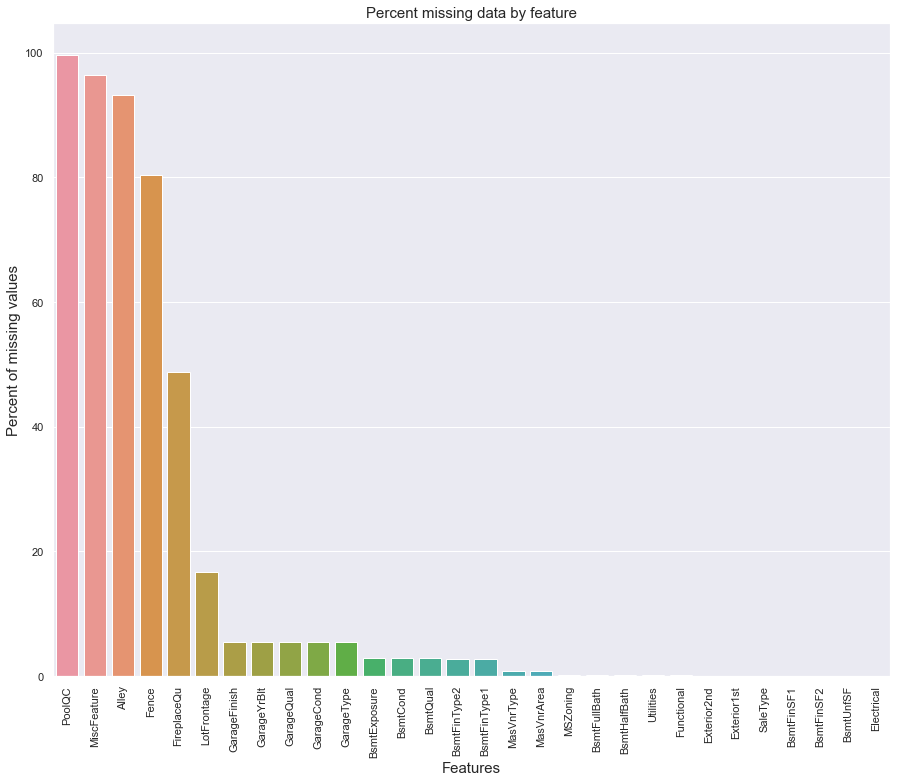

In [181]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [182]:
all_data.PoolQC.loc[all_data.PoolQC.notnull()]

197     Ex
809     Fa
1169    Gd
1181    Ex
1384    Fa
1421    Gd
1972    Ex
2571    Ex
2708    Gd
Name: PoolQC, dtype: object

In [183]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [184]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [185]:
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_data[col] = all_data[col].fillna('None')

In [186]:
abc = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','GarageYrBlt', 'GarageArea', 'GarageCars']
all_data.groupby('GarageType')[abc].count()

,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt,GarageArea,GarageCars
GarageType,,,,,,,
2Types,23,23,23,23,23,23,23
Attchd,1722,1722,1722,1722,1722,1722,1722
Basment,36,36,36,36,36,36,36
BuiltIn,185,185,185,185,185,185,185
CarPort,15,15,15,15,15,15,15
Detchd,779,779,779,779,777,778,778
None,157,157,157,157,0,157,157


In [187]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [188]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [189]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [190]:
all_data['MSZoning'].value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [191]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [192]:
all_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [193]:
all_data = all_data.drop(['Utilities'], axis=1)

In [194]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [195]:
mode_col = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in mode_col:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [196]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [197]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio
BsmtExposure,2.811107
BsmtCond,2.811107
BsmtQual,2.776826
BsmtFinType2,2.742544
BsmtFinType1,2.708262


In [198]:
all_data['OverallCond'].value_counts()

5    1643
6     531
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64

In [199]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [200]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 79)


In [201]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [202]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [203]:
all_data_back = all_data.copy()
skewness.drop('Id', inplace=True)

In [204]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)


There are 59 skewed numerical features to Box Cox transform


In [205]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 221)

In [208]:
train = all_data[:ntrain]
test = all_data[ntrain:]
train.shape

(1458, 221)

In [209]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [210]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [211]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1481 (0.0165)



In [212]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.1114 (0.0075)



In [213]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1114 (0.0075)



In [214]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1156 (0.0077)



In [215]:
LassoMd = lasso.fit(train.values,y_train)
ENetMd = ENet.fit(train.values,y_train)
KRRMd = KRR.fit(train.values,y_train)
GBoostMd = GBoost.fit(train.values,y_train)

In [216]:
finalMd = (np.expm1(LassoMd.predict(test.values)) + np.expm1(ENetMd.predict(test.values)) + np.expm1(KRRMd.predict(test.values)) + np.expm1(GBoostMd.predict(test.values)) ) / 4
finalMd

array([122376.99654558, 166147.21564178, 184888.48855022, ...,
       155612.67418637, 111793.65112078, 219290.24980011])

In [217]:
train_ID = train['Id']
test_ID = test['Id']

In [222]:
sub = pd.DataFrame() # pd.DataFrame(columns=['Id', 'SalePrice'], data = np.vstack(test))
sub['Id'] = test_ID
sub['SalePrice'] = finalMd
output_path = r'C:\Users\Wojtek\Documents\Projects\MLPlayground\output'
sub.to_csv(os.path.join(output_path, "house_prices.csv"), index=False)

In [220]:
sub

,Id,SalePrice
1458,1461,122376.996546
1459,1462,166147.215642
1460,1463,184888.488550
1461,1464,195401.811465
1462,1465,195895.892772
...,...,...
2912,2915,86522.598377
2913,2916,78958.719902
2914,2917,155612.674186
2915,2918,111793.651121


In [64]:
sub

,Id,SalePrice
1458,13.224069,119379.964710
1459,13.226109,163943.016238
1460,13.228148,185082.905442
1461,13.230186,196762.316068
1462,13.232223,193102.793513
...,...,...
2912,15.394418,85799.324665
2913,15.395553,82045.505220
2914,15.396687,169668.989408
2915,15.397821,112211.529841


## Moj kod

In [19]:
Ytr = train['SalePrice']
train.drop(['SalePrice'], axis=1, inplace=True)

In [17]:
whole = train.append(test)
whole.drop('Id', axis=1, inplace=True)

In [18]:
imputer = KNNImputer()

In [19]:
whole_num = whole.select_dtypes(include=[np.number]).iloc[:,1:]

whole_str = whole.select_dtypes(include=[object]).iloc[:,1:]

In [20]:
whole_num = pd.DataFrame(data=imputer.fit_transform(whole_num), columns=whole_num.columns)

In [21]:
#imputer = KNNImputer()
imputer = SimpleImputer(strategy='most_frequent')

whole_str_imputed = pd.DataFrame(imputer.fit_transform(whole_str), columns=whole_str.columns)

In [22]:
whole_str_imputed = whole_str_imputed.apply(preprocessing.LabelEncoder().fit_transform)

In [23]:
whole = pd.concat([whole_num, whole_str_imputed], axis=1)

In [50]:
Xtr = whole.iloc[:train.shape[0], :]
Xte = whole.iloc[train.shape[0]:, :]

In [51]:
whole_num_Xtr = Xtr.select_dtypes(include=[np.number]).iloc[:,1:]

In [52]:
from sklearn.ensemble import IsolationForest
import numpy as np
np.random.seed(1)

clf = IsolationForest( behaviour = 'new', max_samples=100, random_state = 1, contamination= 'auto')
preds = clf.fit_predict(whole_num_Xtr)
preds

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\ensemble\_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


array([ 1,  1,  1, ..., -1,  1,  1])

In [53]:
non_outliers = np.argwhere(preds == 1).flatten()

In [54]:
whole_num_Xtr_filtered = whole_num_Xtr.iloc[non_outliers, :]

In [55]:
Xtr = Xtr.iloc[non_outliers, :]
Ytr = Ytr[non_outliers]

In [56]:
Xtr.head(2)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,...,1,1,4,4,2,0,2,2,8,4
1,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,...,1,1,4,4,2,0,2,2,8,4


In [84]:
# Xtr['GarageYrBlt'].fillna(Xtr['GarageYrBlt'].median(), inplace=True)
# Xtr['MasVnrArea'].fillna(Xtr['MasVnrArea'].median(), inplace=True)
# Xtr['LotFrontage'].fillna(Xtr['LotFrontage'].median(), inplace=True)

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [153]:
# Xte['GarageYrBlt'].fillna(Xte['GarageYrBlt'].median(), inplace=True)
# Xte['LotFrontage'].fillna(Xte['LotFrontage'].median(), inplace=True)
# Xte['MasVnrArea'].fillna(Xte['MasVnrArea'].median(), inplace=True)
# Xte['GarageArea'].fillna(Xte['GarageArea'].median(), inplace=True)

# Xte['BsmtFinSF1'].fillna(Xte['BsmtFinSF1'].median(), inplace=True)
# Xte['BsmtFinSF2'].fillna(Xte['BsmtFinSF2'].median(), inplace=True)
# Xte['BsmtUnfSF'].fillna(Xte['BsmtUnfSF'].median(), inplace=True)
# Xte['TotalBsmtSF'].fillna(Xte['TotalBsmtSF'].median(), inplace=True)

# Xte['BsmtFullBath'].fillna(Xte['BsmtFullBath'].median(), inplace=True)
# Xte['BsmtHalfBath'].fillna(Xte['BsmtHalfBath'].median(), inplace=True)

# Xte['GarageCars'].fillna(Xte['GarageCars'].median(), inplace=True)

In [29]:
Xtr.shape

(1353, 77)

In [155]:
Xte.shape

(1459, 78)

In [42]:
ss = StandardScaler().fit(Xtr)

Xtr = ss.transform(Xtr)
Xte = ss.transform(Xte)

In [43]:
classifier = SVC()

#classifier = LogisticRegression(max_iter=10000)
#classifier = RandomForestClassifier()
#classifier = GradientBoostingClassifier()
classifier.fit(Xtr, Ytr.values)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [44]:
result = classifier.predict(Xte)

In [45]:
model = xgb.XGBRegressor() 

In [46]:
model.fit(Xtr, Ytr.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [47]:
result = model.predict(Xte)

In [48]:
ids = test['Id'].values.astype('int')
output = np.vstack((ids, result))
output = pd.DataFrame(data=output.T, columns=['Id', 'SalePrice'])
output = output.astype('int')
output_path = r'C:\Users\Wojtek\Documents\Projects\MLPlayground\output'
output.to_csv(os.path.join(output_path, "house_prices.csv"), index=False)

In [57]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [60]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, Xtr.values, Ytr.values, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [61]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 253170.9166 (280852.3766)



C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.31642e-19): result may not be accurate.
  overwrite_a=False)
C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.70286e-19): result may not be accurate.
  overwrite_a=False)
C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=6.45988e-19): result may not be accurate.
  overwrite_a=False)
C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.22938e-19): result may not be accurate.
  overwrite_a=False)
C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.52521e-19): result may not be accura

In [62]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213841706742.61926, tolerance: 485673457.4172305
  positive)
C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209848152392.4045, tolerance: 457041905.95866156
  positive)


Lasso score: 21975.7119 (1557.6657)



C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205345632195.9275, tolerance: 479166123.5028881
  positive)
C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225037032403.6984, tolerance: 502943343.47666675
  positive)
C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 224543586298.58395, tolerance: 493614772.09311426
  positive)


In [63]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221664096908.7052, tolerance: 485673457.4172305
  positive)
C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217688200175.67987, tolerance: 457041905.95866156
  positive)
C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206882045568.68073, tolerance: 479166123.5028881
  positive)
C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did n

ElasticNet score: 21977.3045 (1557.9755)



In [64]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 19871.0062 (2040.8360)



In [ ]:
numerical = 

In [13]:
numerical_cols = ['MsSubCLass', 'LotFrontage', 'LotArea', '']



In [4]:
classifier = SVC()